In [46]:
import glob
import json
import os
import pickle
import unicodedata

from sudachipy import tokenizer
from sudachipy import dictionary

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from tqdm.auto import tqdm
%matplotlib inline

In [31]:
pd.options.display.max_rows = pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format

In [32]:
OUTPUT_DIR = os.path.join('..', 'data', 'eda-001')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [33]:
INPUT_DIR = os.path.join(os.path.expanduser('~'), 'datasets', 'nishika', 'bokete')
assert os.path.isdir(INPUT_DIR)
train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

In [34]:
cv = pd.read_csv(os.path.join('..', 'fold', 'cv.csv'))
cv

,odai_photo_file_name,oof_fold
0,9fkys1gb2r.jpg,4
1,c6ag0m1lak.jpg,3
2,whtn6gb9ww.jpg,3
3,6yk5cwmrsy.jpg,0
4,0i9gsa2jsm.jpg,4
...,...,...
24957,5ctq9ohpge.jpg,3
24958,dcj9pepjwf.jpg,1
24959,ks04y4iy7i.jpg,2
24960,cgfkktchbz.jpg,4


In [35]:
words_to_be_removed = ('\t', '\n')

def normalize(text: str) -> str:
    text = unicodedata.normalize('NFKC', text.strip().lower())
    for w in words_to_be_removed:
        text = text.replace(w, '')
    return text

In [36]:
train['normalized_text'] = np.vectorize(normalize)(train['text'])
test['normalized_text'] = np.vectorize(normalize)(test['text'])

In [37]:
pof_exclude = ('助詞', '補助記号', '接尾辞', '接頭辞', '空白', '記号')
sudachi_tokenizer = dictionary.Dictionary(dict_type='full').create()
mode = tokenizer.Tokenizer.SplitMode.C
def analyze_fn(text: str) -> list:
    features = []
    morpheme_list = sudachi_tokenizer.tokenize(text)
    for m in morpheme_list:
        if m.surface() and m.part_of_speech()[0] not in pof_exclude:
            features.append(m.dictionary_form())
    return features

C:\Users\nndropout\AppData\Local\Temp\ipykernel_16076\2245218798.py:2: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_tokenizer = dictionary.Dictionary(dict_type='full').create()


In [38]:
%%time
prediction_train = []
prediction_valid = []
metrics = {'train_loss': [], 'valid_loss': []}
models = []

for oof_fold, fold_df in tqdm(cv.groupby('oof_fold')):

    mask = train['odai_photo_file_name'].isin(fold_df['odai_photo_file_name'])
    X_train = train.loc[mask, 'normalized_text']
    y_train = train.loc[mask, 'is_laugh']
    X_valid = train.loc[~mask, 'normalized_text']
    y_valid = train.loc[~mask, 'is_laugh']

    model = Pipeline(
        steps=[
            ('vectorizer', TfidfVectorizer(analyzer=analyze_fn, min_df=10, max_df=5000)),
            ('decomposer', TruncatedSVD(n_components=100, random_state=422)),
            ('classifier', CalibratedClassifierCV(SVC(random_state=293847), method='isotonic', n_jobs=-1, cv=5))
        ]
    ).fit(X_train, y_train)
    models.append(model)

    pred_train = model.predict_proba(X_train)[:, -1]
    pred_valid = model.predict_proba(X_valid)[:, -1]
    loss_train = log_loss(y_train, pred_train)
    loss_valid = log_loss(y_valid, pred_valid)

    metrics['train_loss'].append(loss_train)
    metrics['valid_loss'].append(loss_valid)

    prediction_train_ = pd.DataFrame({
        'id': train.loc[mask, 'id'].to_numpy(),
        'probability': pred_train
    })
    prediction_train.append(prediction_train_)

    prediction_valid_ = pd.DataFrame({
        'id': train.loc[~mask, 'id'].to_numpy(),
        'probability': pred_valid
    })
    prediction_valid.append(prediction_valid_)

    print(f'Fold {oof_fold}: Training loss={loss_train:.5f}, Validation loss={loss_valid:.5f}')

prediction_train = pd.concat(prediction_train)
prediction_valid = pd.concat(prediction_valid)
np.mean(metrics['train_loss']), np.mean(metrics['valid_loss'])

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: Training loss=0.62220, Validation loss=0.67628
Fold 1: Training loss=0.60800, Validation loss=0.67519
Fold 2: Training loss=0.60613, Validation loss=0.67594
Fold 3: Training loss=0.61362, Validation loss=0.67754
Fold 4: Training loss=0.58839, Validation loss=0.68031
CPU times: total: 5min 19s
Wall time: 6min 59s


(0.6076661109109895, 0.6770509876649471)

In [39]:
with open(os.path.join(OUTPUT_DIR, 'result.json'), 'w') as f:
    json.dump(metrics, f)

In [40]:
with open(os.path.join(OUTPUT_DIR, 'models'), 'wb') as f:
    pickle.dump(models, f)

In [41]:
prediction_train.to_csv(os.path.join(OUTPUT_DIR, 'prediction_train.csv'), index=False)
prediction_valid.to_csv(os.path.join(OUTPUT_DIR, 'prediction_valid.csv'), index=False)

In [42]:
prediction_test = []
for model in models:
    pred_test = model.predict_proba(test['normalized_text'])[:, -1]
    prediction_test_ = pd.DataFrame({
        'id': test['id'].to_numpy(),
        'probability': pred_test
    })
    prediction_test.append(prediction_test_)

prediction = pd.concat(prediction_test).groupby('id')['probability'].mean()
prediction

id
00256fqr5   0.522
00dg8czme   0.493
00kwnamds   0.521
00wegkbsp   0.352
02bo41c14   0.375
             ... 
zzbeh6ptp   0.560
zzbme8old   0.622
zzksgrtmg   0.352
zzv1jjbke   0.448
zzweow5o7   0.352
Name: probability, Length: 6000, dtype: float64

In [43]:
sample_submission['is_laugh'] = prediction.loc[sample_submission['id']].to_numpy()
sample_submission

,id,is_laugh
0,rfdjcfsqq,0.550
1,tsgqmfpef,0.484
2,owjcthkz2,0.352
3,rvgaocjyy,0.426
4,uxtwu5i69,0.519
...,...,...
5995,vx1lpzark,0.517
5996,y9sugbhm8,0.670
5997,dsd1yixzk,0.499
5998,vmyopn0mu,0.408


count   6000.000
mean       0.502
std        0.091
min        0.242
25%        0.436
50%        0.514
75%        0.568
max        0.805
Name: is_laugh, dtype: float64

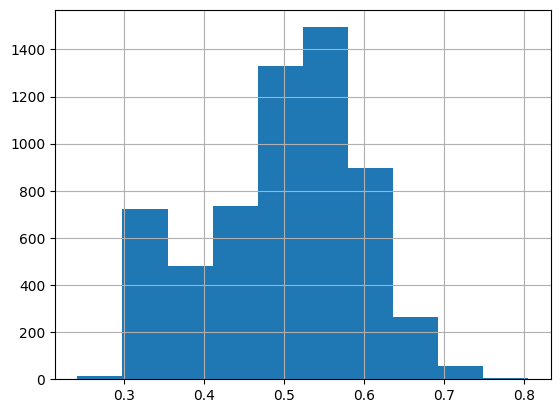

In [47]:
sample_submission['is_laugh'].hist()
sample_submission['is_laugh'].describe()

In [48]:
sample_submission.to_csv(os.path.join(OUTPUT_DIR, f'submission_{os.path.split(OUTPUT_DIR)[-1]}.csv'), index=False)